In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Error: (compiled mode) evaluation error starting at /home/vavrines/.julia/packages/DistributionsAD/dKKOw/src/reversediff.jl:26
│   mod = DistributionsAD.ReverseDiffX
│   ex = begin
    #= /home/vavrines/.julia/packages/DistributionsAD/dKKOw/src/reversediff.jl:26 =#
    const RDBroadcasted{F, T} = Broadcasted{<:Any, <:Any, F, T}
end
│   exception = (ErrorException("invalid redefinition of constant RDBroadcasted"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f60a7f1c72f, Ptr{Nothing} @0x00007f60a7fa994c, Ptr{Nothing} @0x00007f60a7fac0f8, Ptr{Nothing} @0x00007f60a7facfe7, Base.InterpreterIP in top-level CodeInfo for DistributionsAD.ReverseDiffX at statement 15])
└ @ Revise /home/vavrines/.julia/packages/Revise/BqeJF/src/lowered.jl:85


In [ ]:
function device_data(x)
    try
        gpu(x)
    catch
        cpu(x)
    end
end

In [2]:
@load "sol1d.jld2" ks ctr

2-element Array{Symbol,1}:
 :ks
 :ctr

In [ ]:
plot_line(ks, ctr)

In [3]:
vMeshType = "rectangle"
umin = ks.vSpace.u0; umax = ks.vSpace.u1; nu = ks.vSpace.nu
vmin = ks.vSpace.u0; vmax = ks.vSpace.u1; nv = 28
wmin = ks.vSpace.u0; wmax = ks.vSpace.u1; nw = 28
nm = 5; tLen = 3; nh = 12;

In [4]:
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, ks.gas.γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length=tLen);

In [5]:
#--- Boltzmann dataset ---#
f_full = Array{Float32}(undef, ks.vSpace.nu, nv, nw, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    f_full[:, :, :, i] .= full_distribution(
        ctr[i].h,
        ctr[i].b,
        ks.vSpace.u,
        ks.vSpace.weights,
        vSpace3D.v,
        vSpace3D.w,
        ctr[i].prim,
        ks.gas.γ,
    )
end

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    ks.gas.αᵣ,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

#data_boltz = zeros(Float32, ks.vSpace.nu, nv, nw, ks.pSpace.nx, tLen)
data_boltz = zeros(Float32, ks.vSpace.nu, nv, nw, ks.pSpace.nx, 2)
for i = 1:ks.pSpace.nx
    prob = ODEProblem(
        boltzmann!,
        f_full[:, :, :, i],
        tspan,
        [kn_bzm, nm, phi, psi, phipsi],
    )

    #data_boltz[:, :, :, i, :] = solve(prob, Tsit5(), saveat = tran) |> Array
    data_boltz[:, :, :, i, :] = solve(prob, Euler(), dt = dt) |> Array
end

# time series
#h_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
#b_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
#for j = 1:tLen, i = 1:ks.pSpace.nx 

# forward euler
h_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, 2)
b_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, 2)
for j = 1:2, i = 1:ks.pSpace.nx 
    h_boltz[:, i, j], b_boltz[:, i, j] = reduce_distribution(
        data_boltz[:, :, :, i, j],
        vSpace3D.v,
        vSpace3D.w,
        vSpace2D.weights,
    )
end
Y = vcat(h_boltz, b_boltz);

In [6]:
#--- BGK dataset ---#
function bgk!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

X = Array{Float32}(undef, nu * 2, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    X[1:nu, i] .= ctr[i].h
    X[nu+1:end, i] .= ctr[i].b
end

H = Array{Float32}(undef, nu, ks.pSpace.nx)
B = Array{Float32}(undef, nu, ks.pSpace.nx)
τ = Array{Float32}(undef, 1, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    H[:, i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* ctr[i].prim[end])
    τ[1, i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end
P = [H, B, τ]

prob = ODEProblem(bgk!, X, tspan, P)
#Y1 = solve(prob, Midpoint(), saveat = tran) |> Array;
Y1 = solve(prob, Euler(), dt=dt) |> Array;

In [7]:
X_data = cpu(X); Y_data = cpu(Y)
H_data = cpu(H); B_data = cpu(B); τ_data = cpu(τ);

#X_data = gpu(X); Y_data = gpu(Y1)
#H_data = gpu(H); B_data = gpu(B); τ_data = gpu(τ);

#X_data = device_data(X); Y_data = device_data(Y)
#H_data = device_data(H); B_data = device_data(B); τ_data = device_data(τ);

In [10]:
#--- universal differential equation ---#
model_univ = FastChain(
    #(x, p) -> x.^3,
    #(x, p) -> (zeros(eltype(x), size(x))),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh), # tanh
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2 * nh, tanh), # tanh
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ) #|> gpu
#p_model .= 0.

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = ((H_data .- h) ./ τ_data .+ model_univ(f, p)[1:nu, :])
    db = ((B_data .- b) ./ τ_data .+ model_univ(f, p)[nu+1:end, :])

    df = vcat(dh, db)
end

#function dfdt!(df, f, p, t)
#    h = f[1:nu, :]
#    b = f[nu+1:end, :]

#    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
#    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

#    df[1:nu, :] .= dh
#    df[nu+1:end, :] .= db
#end

prob_ube = ODEProblem(dfdt, X_data, tspan, p_model)

function loss(p)
    #sol_ube = solve(prob_ube, Midpoint(), u0=X_data, p=p, saveat=tran)
    sol_ube = solve(prob_ube, Euler(), u0=X_data, p=p, dt=dt)
    
    #loss = sum(abs2, cpu(sol_ube) .- Y_data)
    loss = sum(abs2, Array(sol_ube) .- Y_data)
    return loss
end

cb = function (p, l)
    #display(l)
    return false
end

#7 (generic function with 1 method)

In [9]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

loss: 0.00161: 100%|█████████████████████████████████████████| Time: 0:00:55


 * Status: success

 * Candidate solution
    Final objective value:     1.611796e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   93  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [11]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=400)

loss: 0.00157: 100%|█████████████████████████████████████████| Time: 0:01:54


 * Status: success

 * Candidate solution
    Final objective value:     1.571591e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   118  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


In [ ]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, LBFGS(), cb=Flux.throttle(cb, 1), maxiters=200)

In [35]:
function nbe_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ model_univ(f, p_nn)[1:nu]
    db = (B .- b) ./ τ .+ model_univ(f, p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    nbe_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; cpu(res.minimizer)],
);

In [36]:
function step_nbe!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    p,
    dx,
    tran,
    RES,
    AVG,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)
    
    #qf = heat_flux(h, b, prim, u, weights)
    #SH, SB = shakhov(u, H, B, qf, prim, ks.gas.Pr, K)
    
    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    #--- update f^{n+1} ---#
    sol = solve(ube, Euler(), u0=[h; b], p=[H; B; τ; p], dt=dt)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[H; B; τ; p], saveat=tran)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[SH; SB; τ; p], saveat=tran)
    
    hstar = sol.u[end][1:length(h)]
    bstar = sol.u[end][length(h)+1:end]
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end

end

step_nbe! (generic function with 1 method)

In [37]:
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

sumRes = zeros(Float32, axes(ks.ib.wL))
sumAvg = zeros(Float32, axes(ks.ib.wL));

p_optim = cpu(res.minimizer);

In [38]:
# loop of neural Boltzmann equation
@showprogress for iter = 1:20
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_nbe!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            p_optim,
            ctr[i].dx,
            tran,
            sumRes,
            sumAvg,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


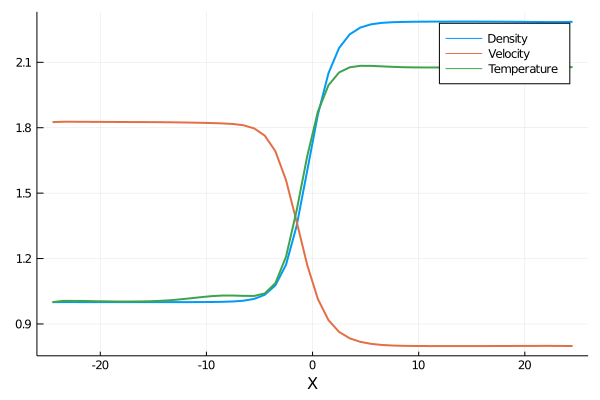

In [39]:
plot_line(ks, ctr)

In [ ]:
residual = Array{Float32}(undef, 3)

@showprogress for iter = 1:2000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [ ]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [ ]:
#--- neural ODE ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    df = model_univ(f, p)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end

In [ ]:
res.minimizer 